## Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

## If not already created, make save folder for figures

In [2]:
save_folder = r'two-disclination-flow-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

## Import necessary packages, add loading bars, make plots big

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifference as fd
import LiquidCrystalHelper as lch
import biharm as bh

import time
from importlib import reload

In [4]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [5]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelper.py'>

In [6]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

## Begin with a $513\times 513$ grid, with one $+1/2$ disclination and one $-1/2$ disclination
* The reason for this odd choice of size is that the FFT works best on an array of size $N = 2^i - 1$ (and the same for the other dimension).
* In this algorithm, the thing that is being Fourier Transformed is the interior points of our domain. This will be $255\times 255$ since the endpoints in either dimension are cutoff.
* Clearly this is $(2^i - 1)\times(2^i - 1)$ for $i = 8$. 

### Set up domain

In [99]:
l = 140
n = 1025

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

### Create two disclinations, get auxiliary variables

In [100]:
S_val = 0.5
ctr = [[-35, 0], [35, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

### Get initial eigenvectors/eigenvalues, plot

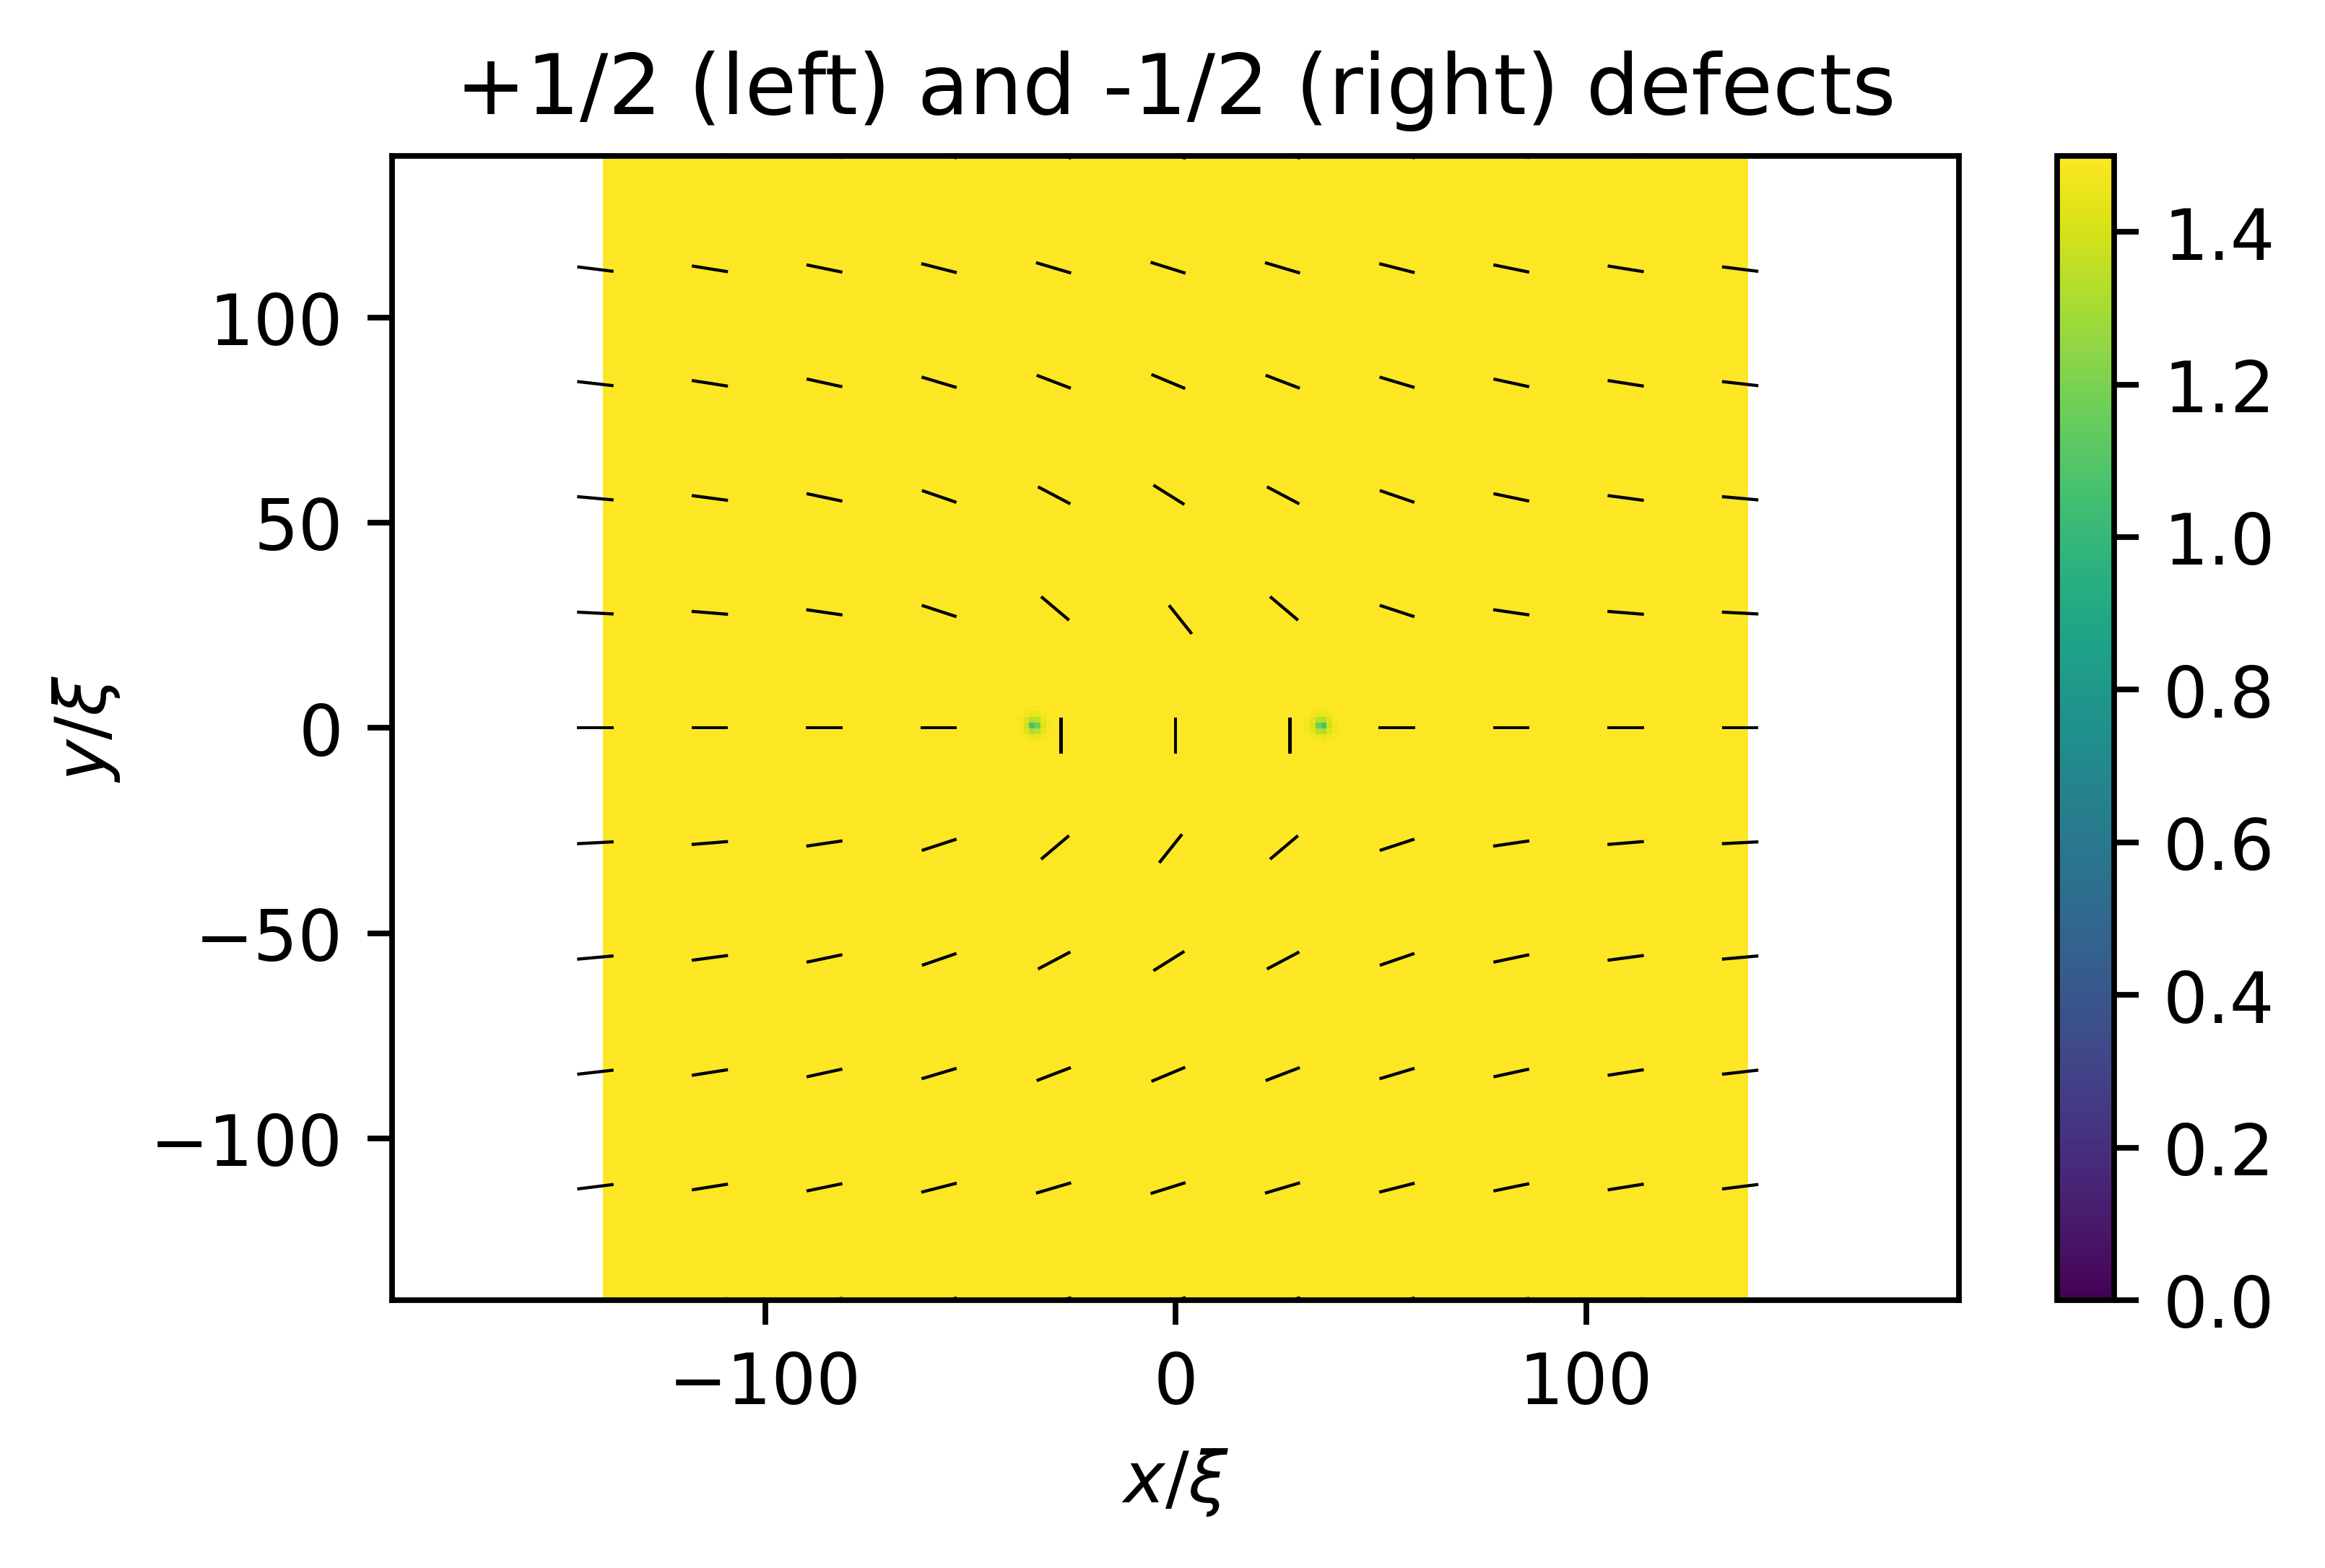

In [101]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx], vmin=0, vmax=1.5)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

filenamet0 = os.path.join(save_folder, r'two-disclinations-t0-config.png')
fig.savefig(filenamet0)

### First, see how long it takes the configuration to relax

In [102]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = 50
num_peaks = 2
peak_pos = np.zeros((num_peaks, num_steps))
peak_val = np.zeros((num_peaks, num_steps))
t = np.zeros(num_steps)

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps - 1)
display(progress)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= 2:
        peak_pos[:, i] = X[peaks][0:2]
        peak_val[:, i] = lambda_max[peaks][0:2]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# Save given auxiliary variable values
eta_hydro = eta_old
mu_hydro = mu_old
nu_hydro = nu_old
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos = peak_pos[:, :i]
peak_val = peak_val[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=49)

Simulation ran in 0.35746203166666723 minutes.


Text(0, 0.5, '$\\lambda_\\mathrm{max}$')

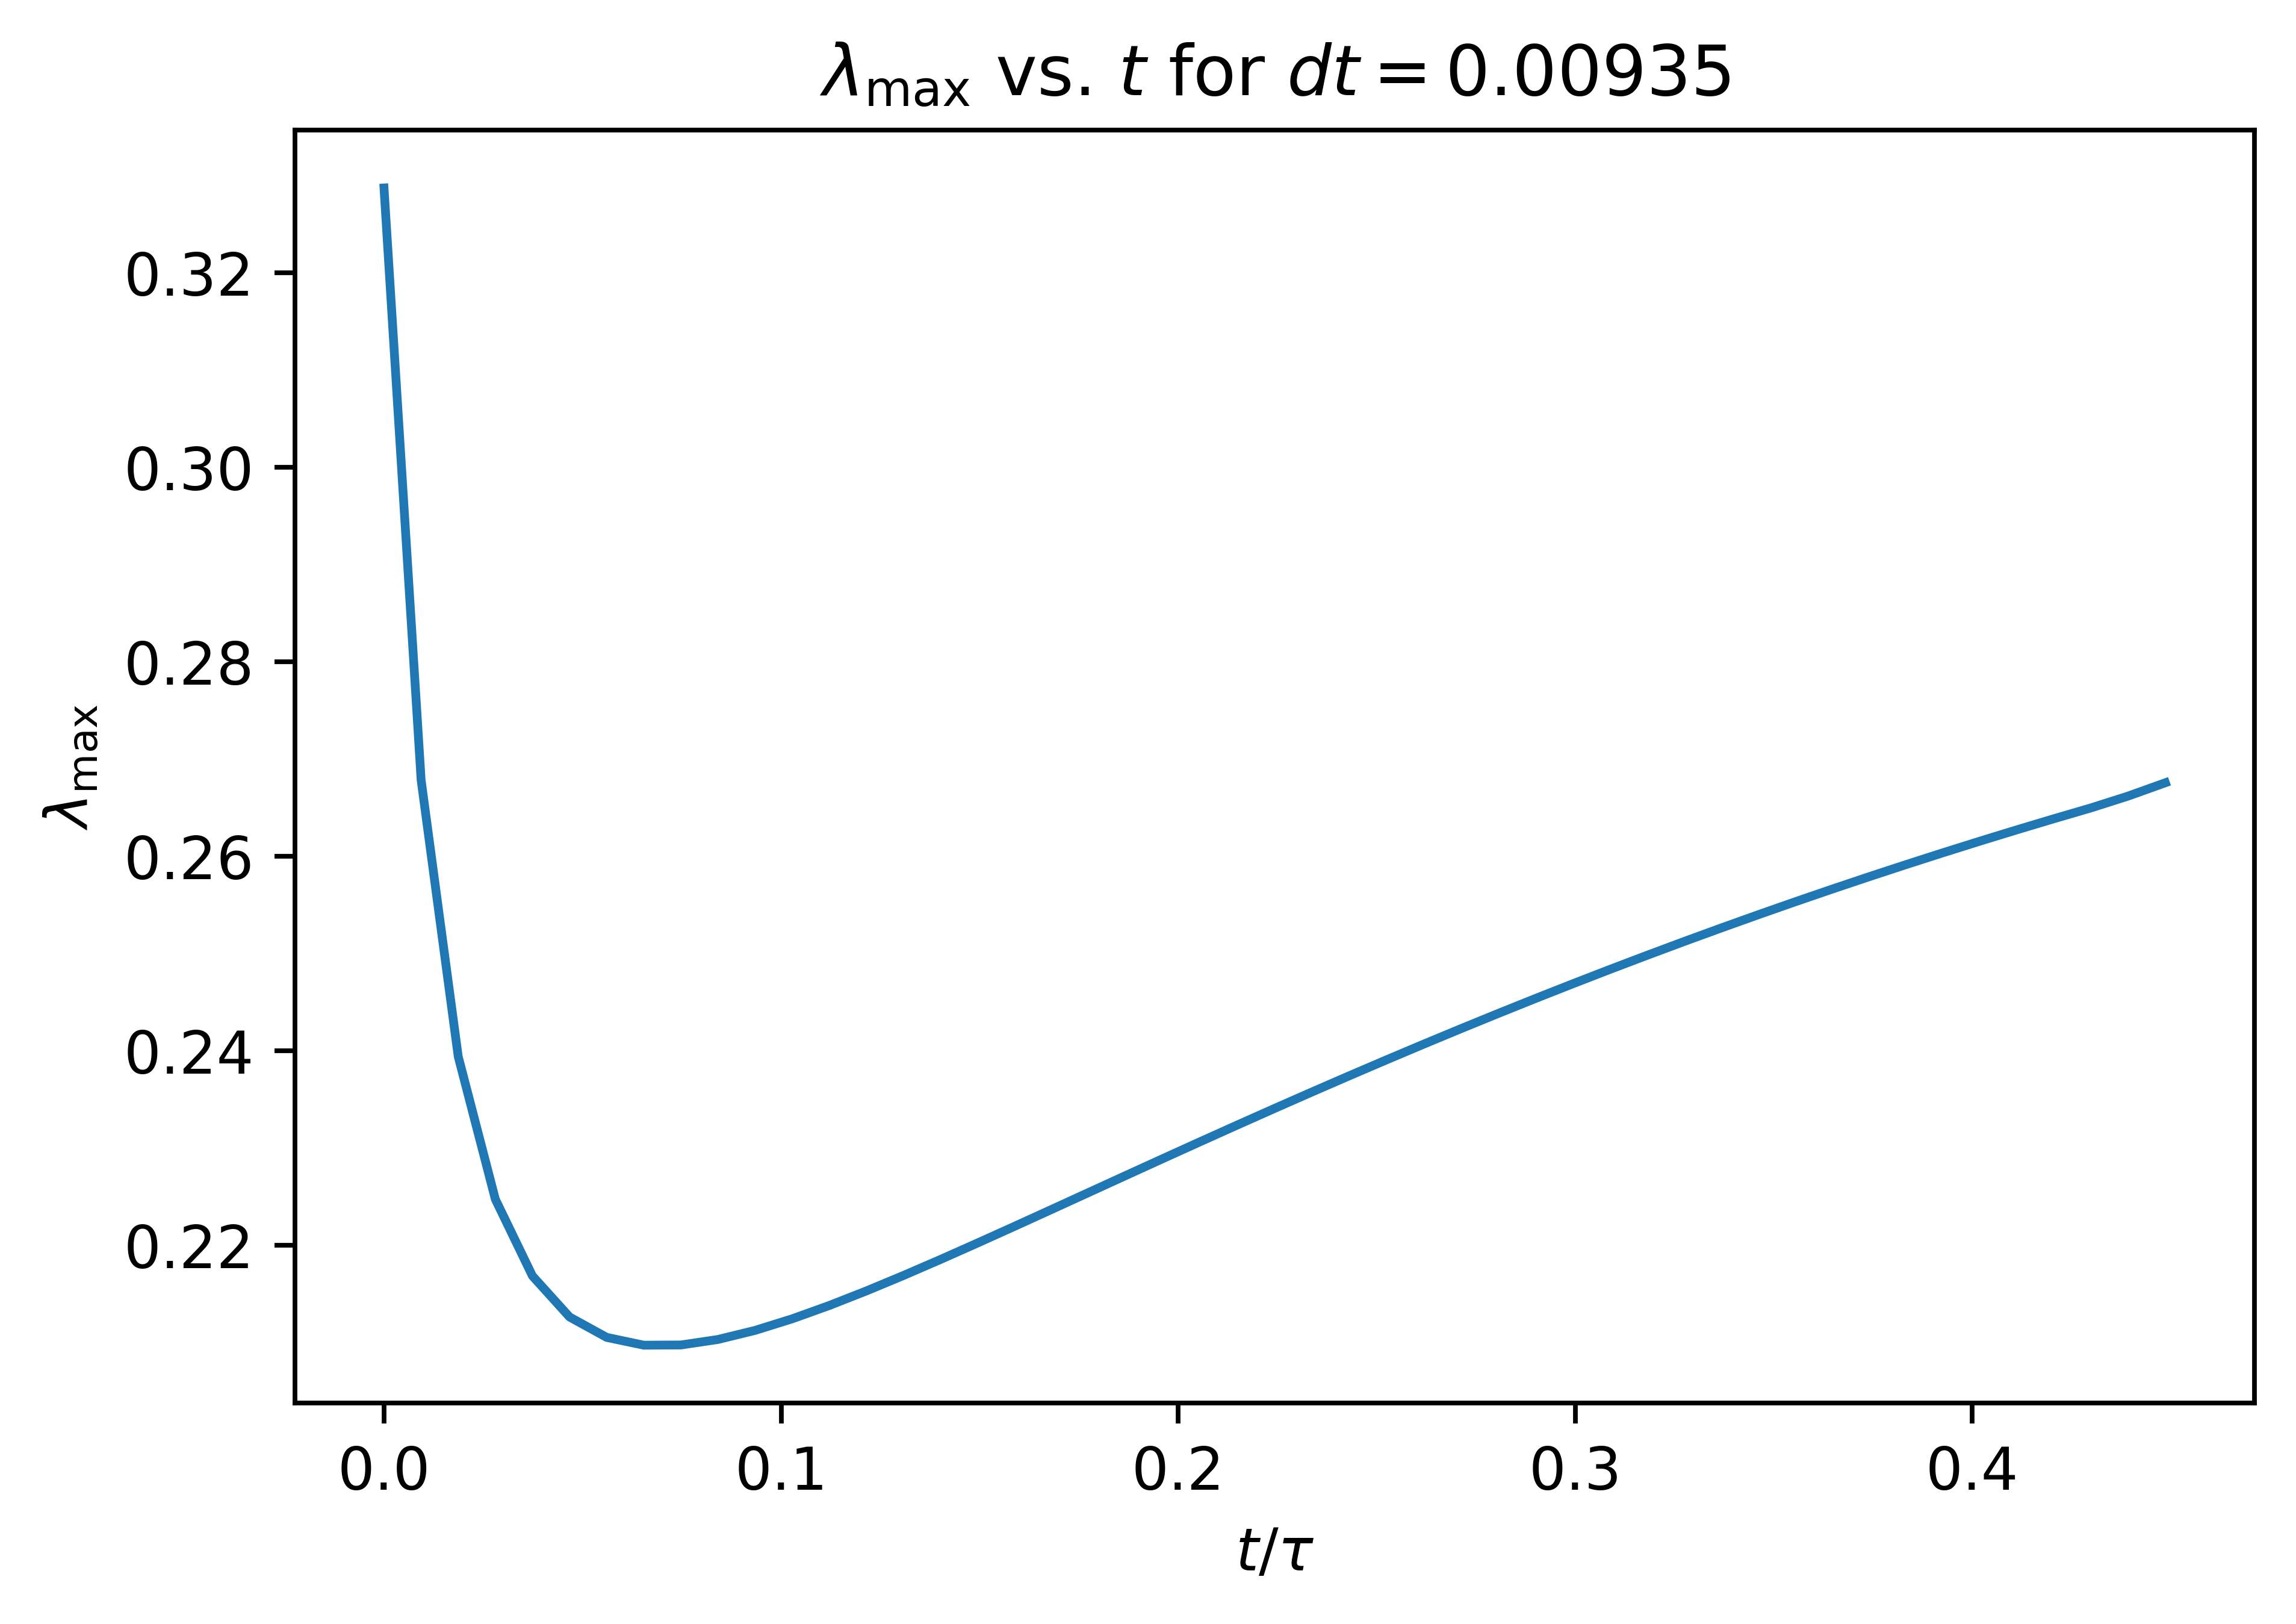

In [103]:
plt.plot(t, peak_val[0, :])
plt.title(r'$\lambda_\mathrm{max}$ vs. $t$ for $dt = $' + str(round(dt, 5)))
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$\lambda_\mathrm{max}$')

### Set up biharmonic solver

In [104]:
L = [2*l, 2*l]
shape = [n - 1, n - 1]
alpha = lch.alpha
maxiter = 500

bh_solver = bh.Biharm(L, shape, alpha, cg_maxiter=maxiter)

### Now add in the hydrodynamic effects and run for a couple of steps to make sure it doesn't fall apart
* Note that for a $257\times 257$ grid it takes about 0.18 seconds per step.
* `dt` in this case is 0.0703125.
* It takes about 1700 units of $t/\tau$ for this to converge.
* That's ~24,200 time steps
* In machine time that yields 4,356 seconds or 72 minutes

In [105]:
num_steps = 10
num_peaks = 2
peak_pos_x = np.zeros((num_peaks, num_steps))
peak_pos_y = np.zeros((num_peaks, num_steps))
peak_val = np.zeros((num_peaks, num_steps))
t = np.zeros(num_steps)

psi = np.zeros(eta_old.shape)

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps - 1)
display(progress)

# Set auxiliary variables to start at end of relaxation
eta_old = eta_hydro
mu_old = mu_hydro
nu_old = nu_hydro

start_time = time.perf_counter()
for i in range(num_steps):
    
    source_term = ( lch.beta*lch.f1(eta_old, mu_old, nu_old, dx) 
                    + (1/4)*lch.alpha*lch.f2(eta_old, mu_old, nu_old, dx) )
    psi[1:-1, 1:-1], info, calls = bh_solver.solve(source_term[1:-1, 1:-1])
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaFlowEOM, mu_old, nu_old, psi, dx)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muFlowEOM, eta_old, nu_old, psi, dx)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks = lch.findMinima(lambda_max)
    if len(peaks[0]) <= num_peaks:
        peak_pos_x[:, i] = X[peaks][0:2]
        peak_pos_y[:, i] = Y[peaks][0:2]
        peak_val[:, i] = lambda_max[peaks][0:2]
    else:
        break
        
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
# truncate arrays if loop stops early
t = t[:i]
peak_pos_x = peak_pos_x[:, :i]
peak_pos_y = peak_pos_y[:, :i]
peak_val = peak_val[:, :i]
    
end_time = time.perf_counter()
print("Simulation ran in", (end_time - start_time)/60, "minutes.")

IntProgress(value=0, max=9)

Simulation ran in 1.072658235000002 minutes.


Text(0, 0.5, '$y/\\xi$')

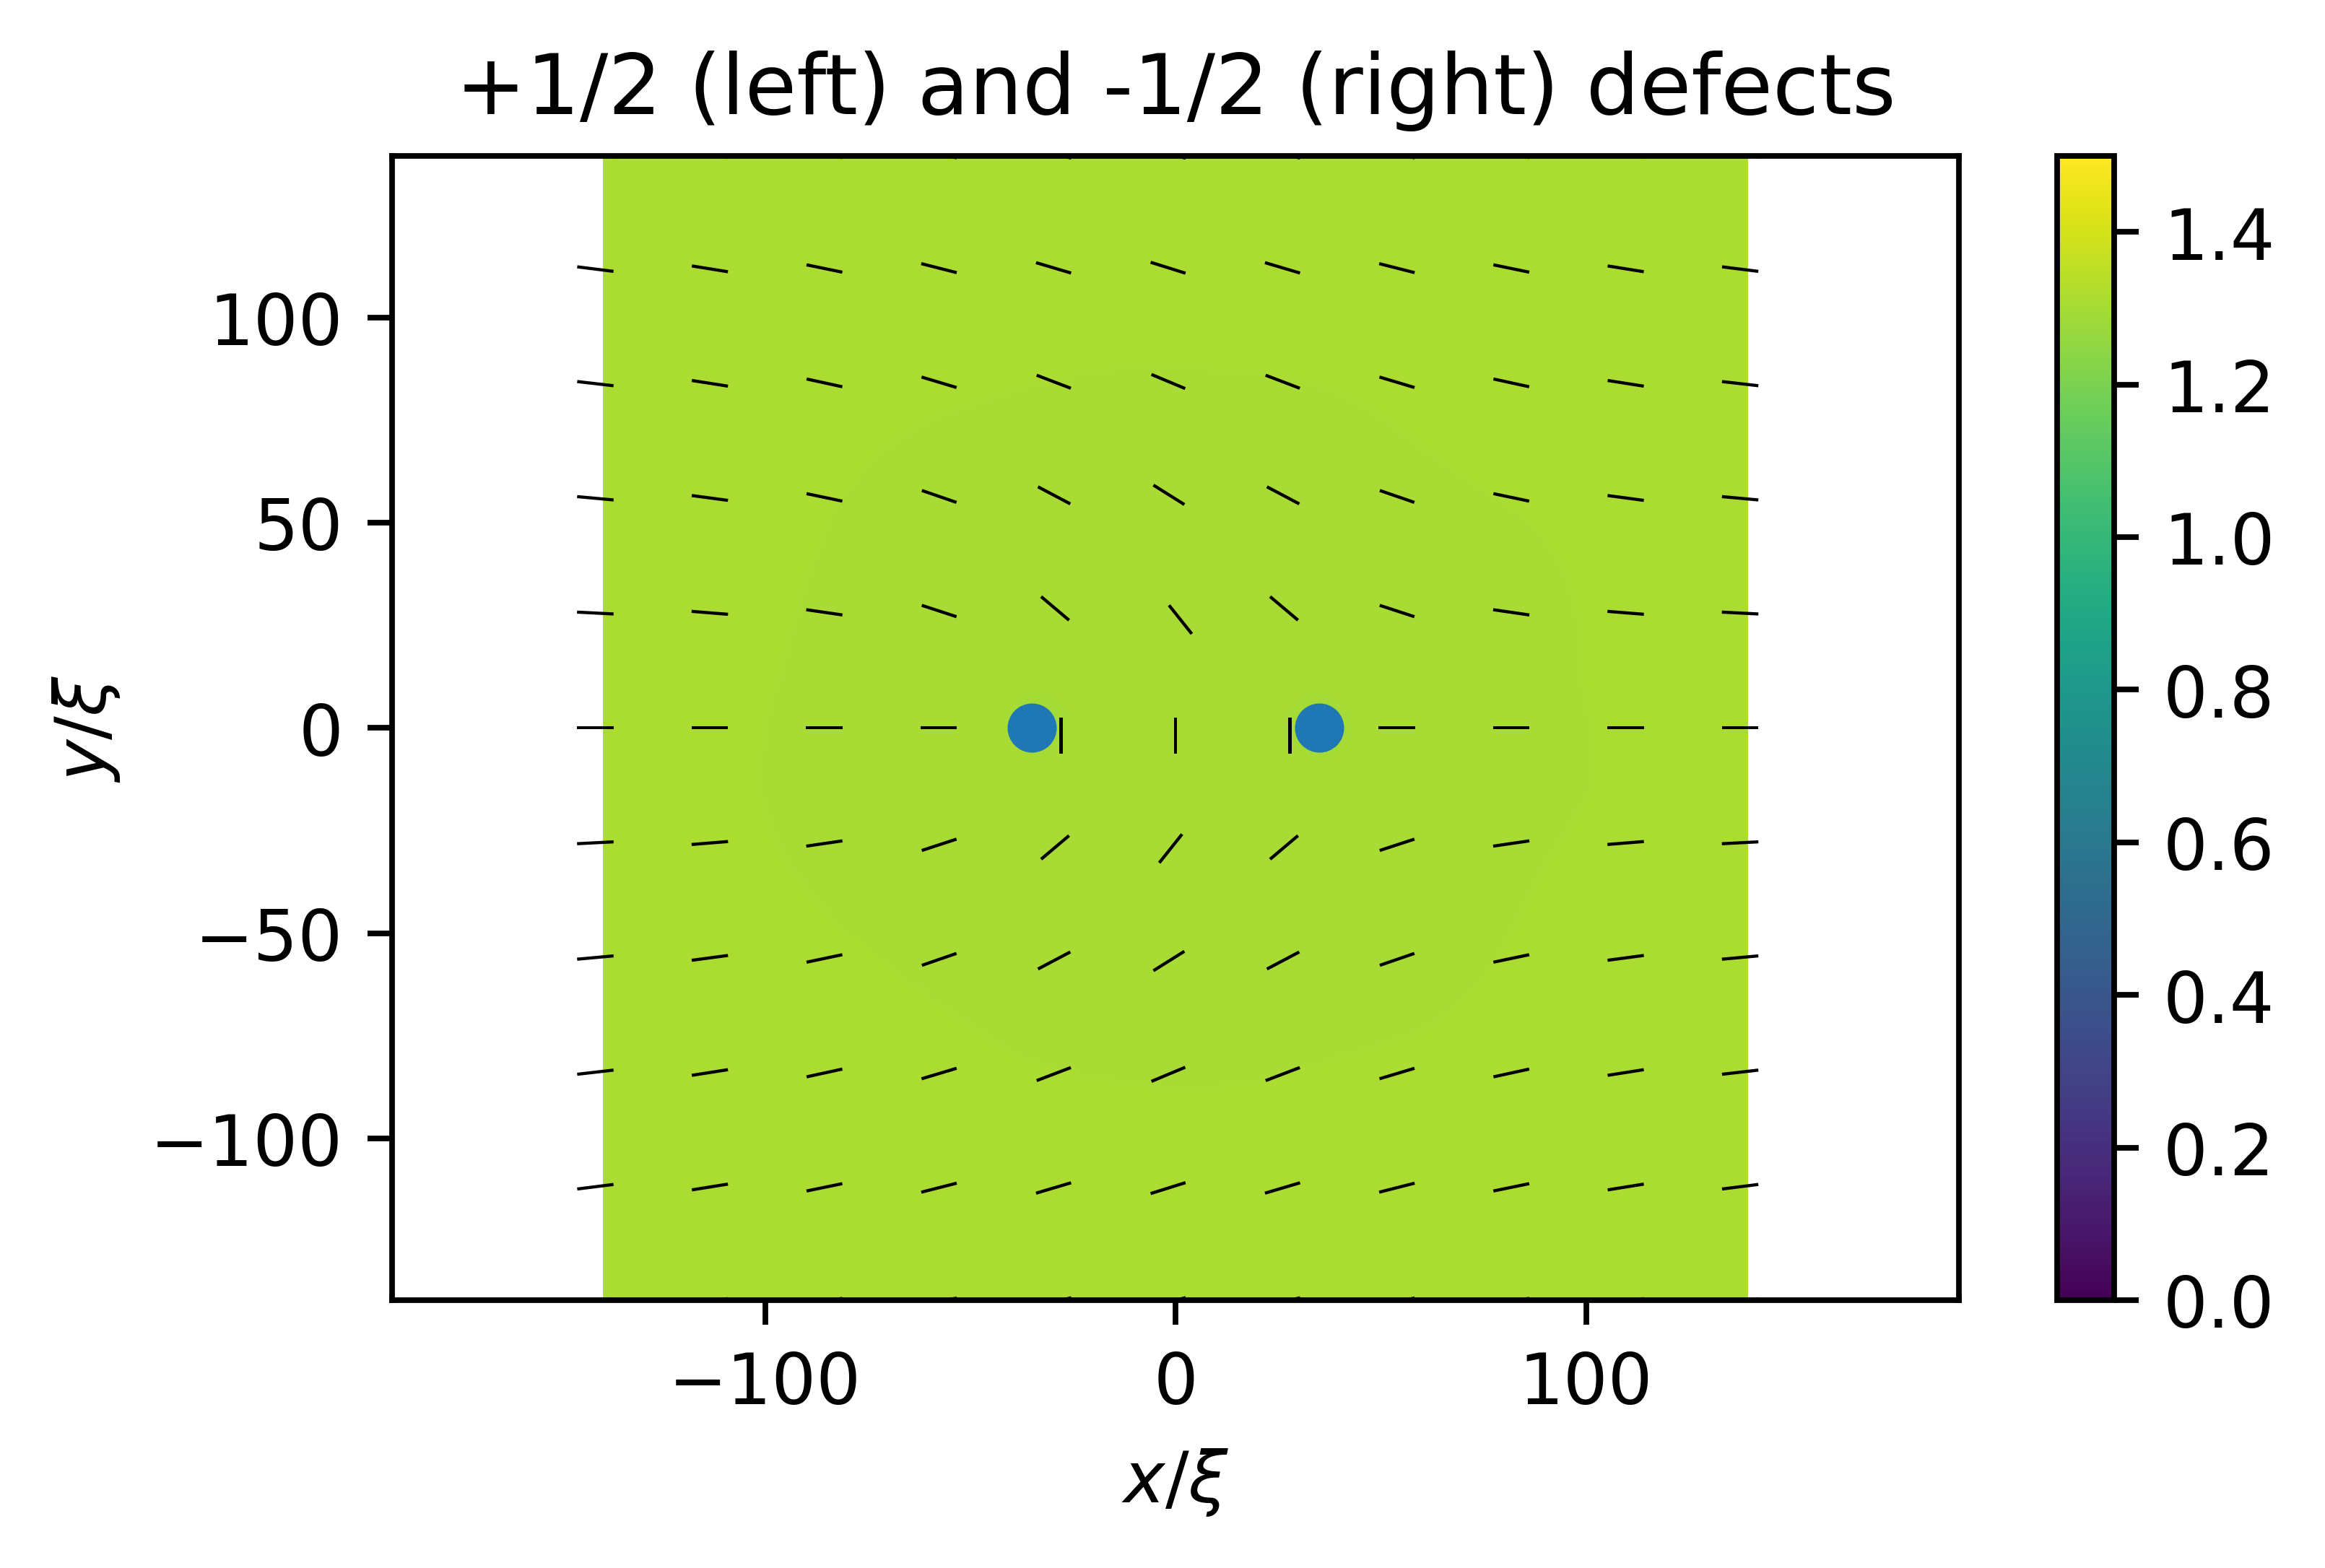

In [106]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
U, V = lch.calcQEigenvecs(eta_old, mu_old, nu_old, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx], vmin=0, vmax=1.5)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.plot(peak_pos_x[:, -1], peak_pos_y[:, -1], marker='o', ls='')

ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

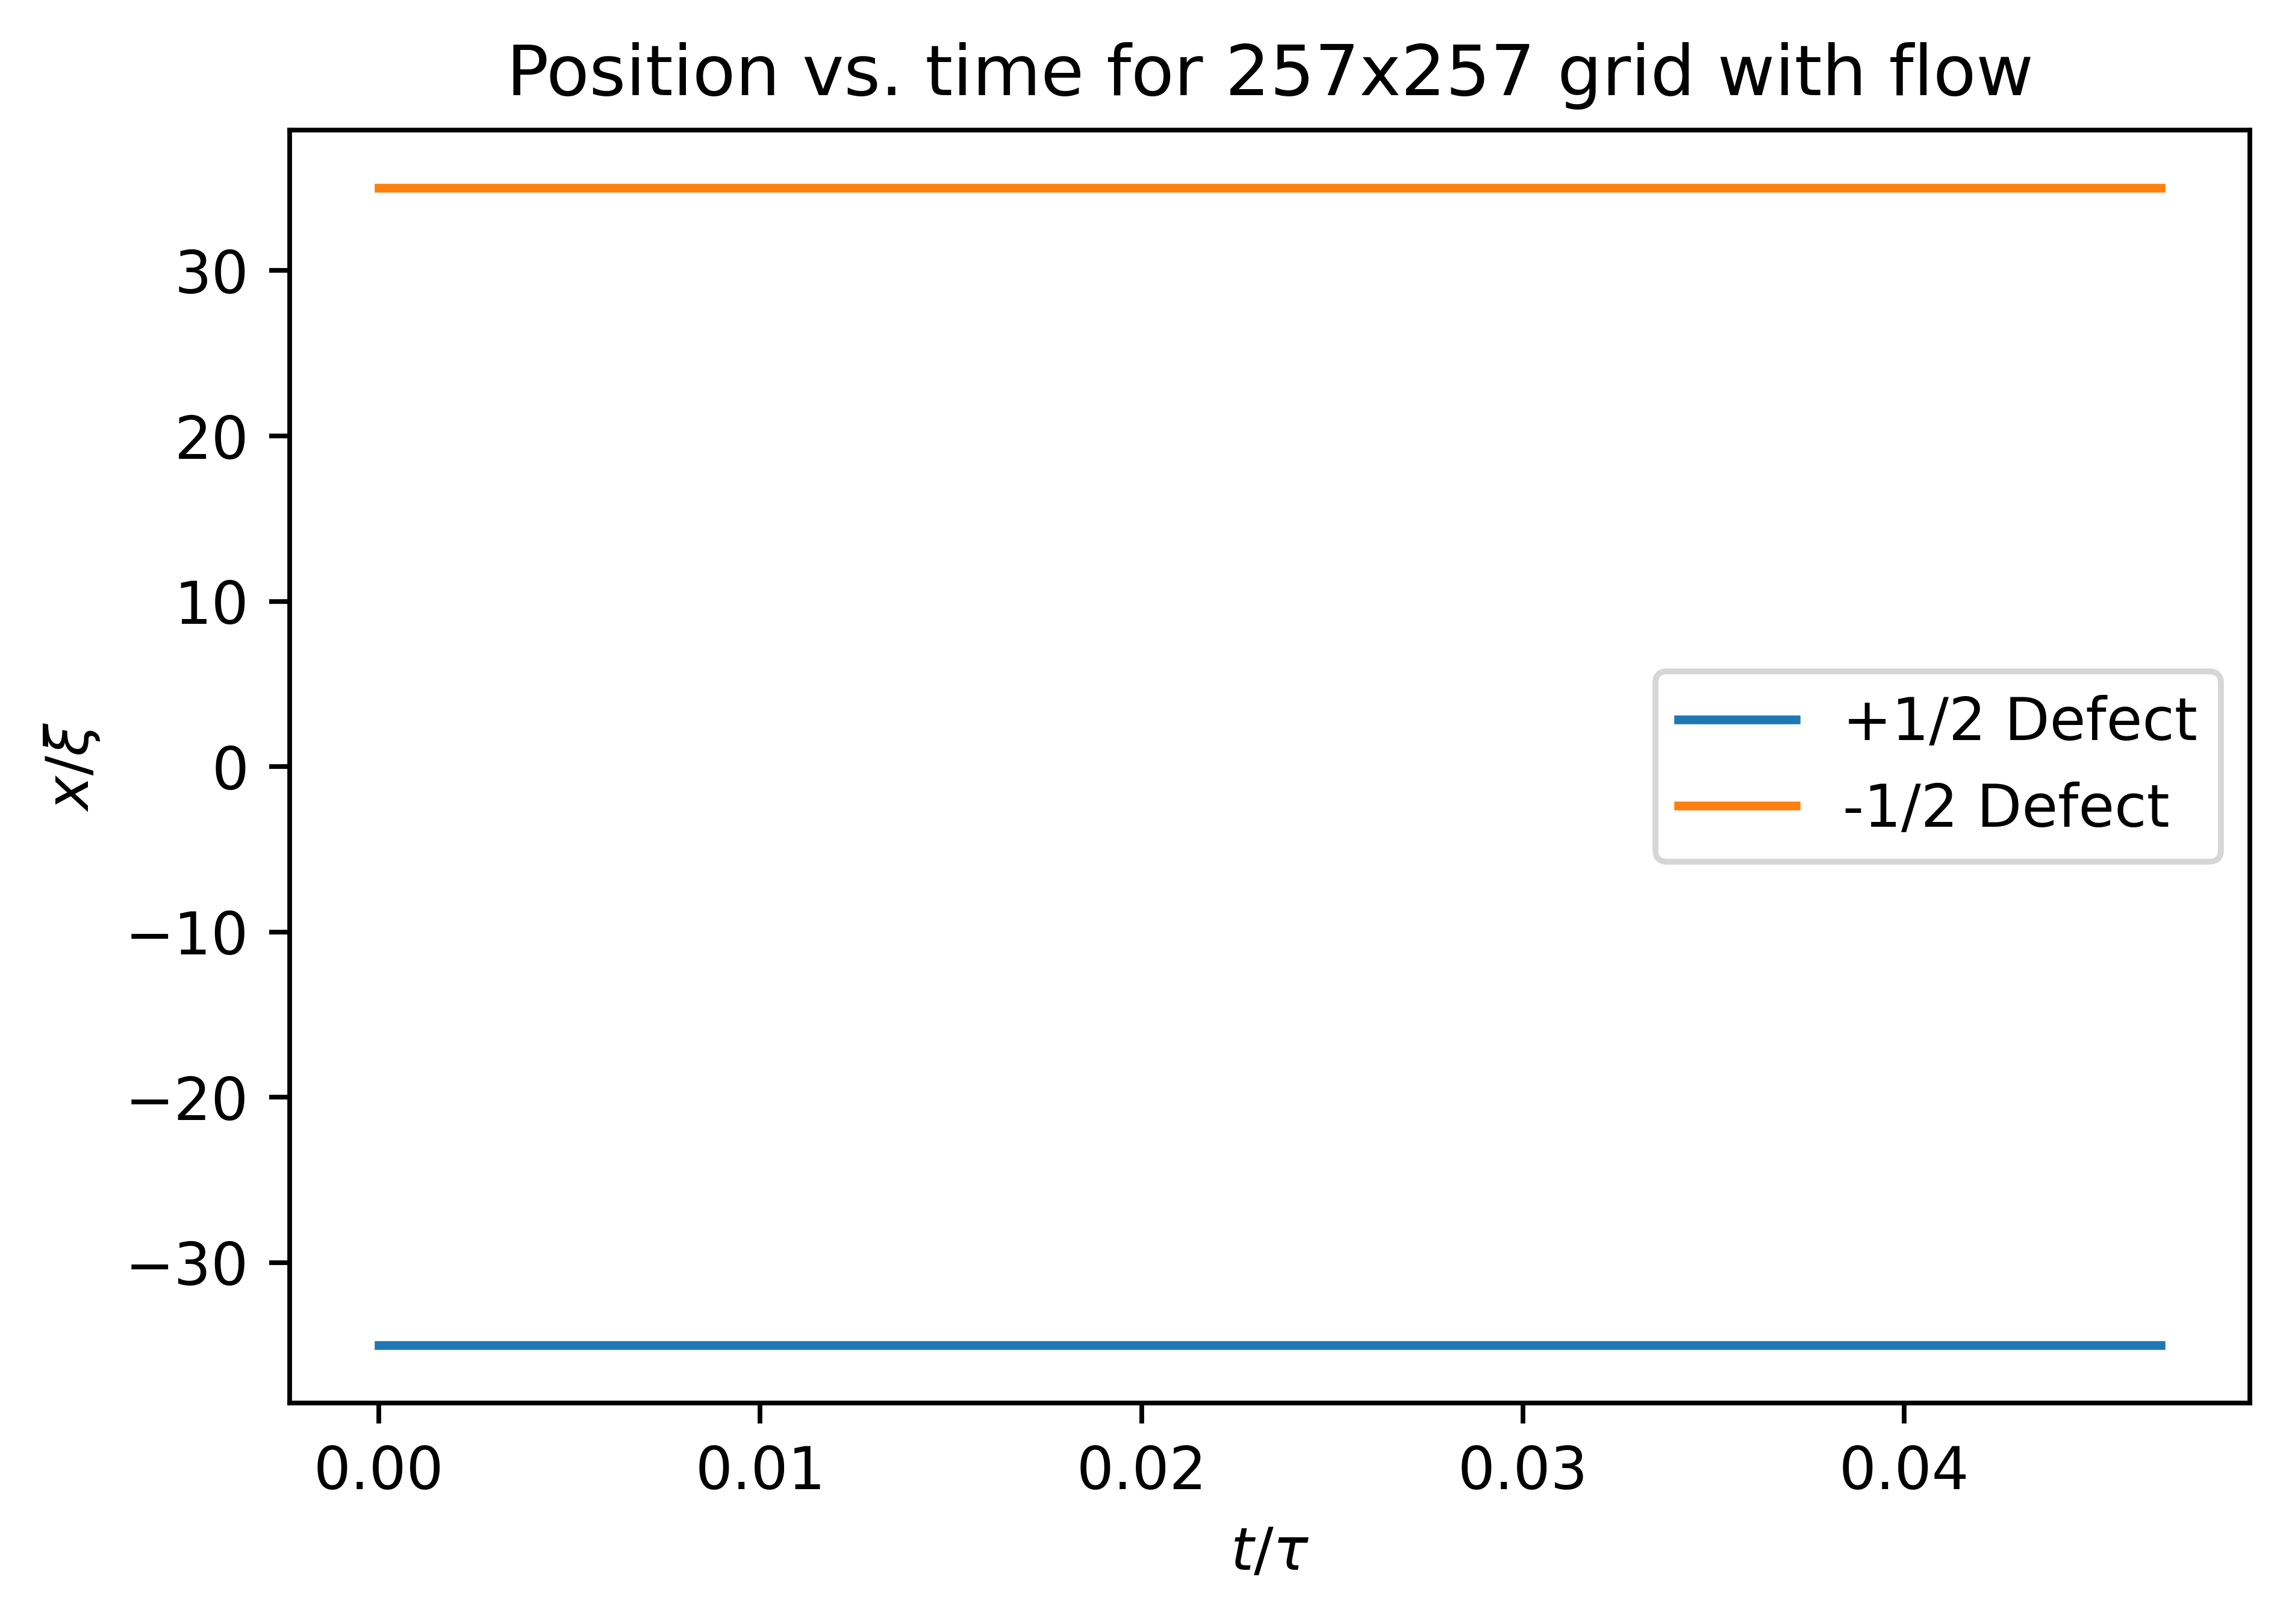

In [107]:
plt.plot(t, peak_pos_x[0, :], label='+1/2 Defect')
plt.plot(t, peak_pos_x[1, :], label='-1/2 Defect')

plt.title('Position vs. time for 257x257 grid with flow')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$x/\xi$')
plt.legend()

# filename_defect_pos_vs_time = os.path.join(save_folder, r'defect-pos-vs-time-257pts-with-flow.png')
# plt.savefig(filename_defect_pos_vs_time)

Text(0, 0.5, '$y/\\xi$')

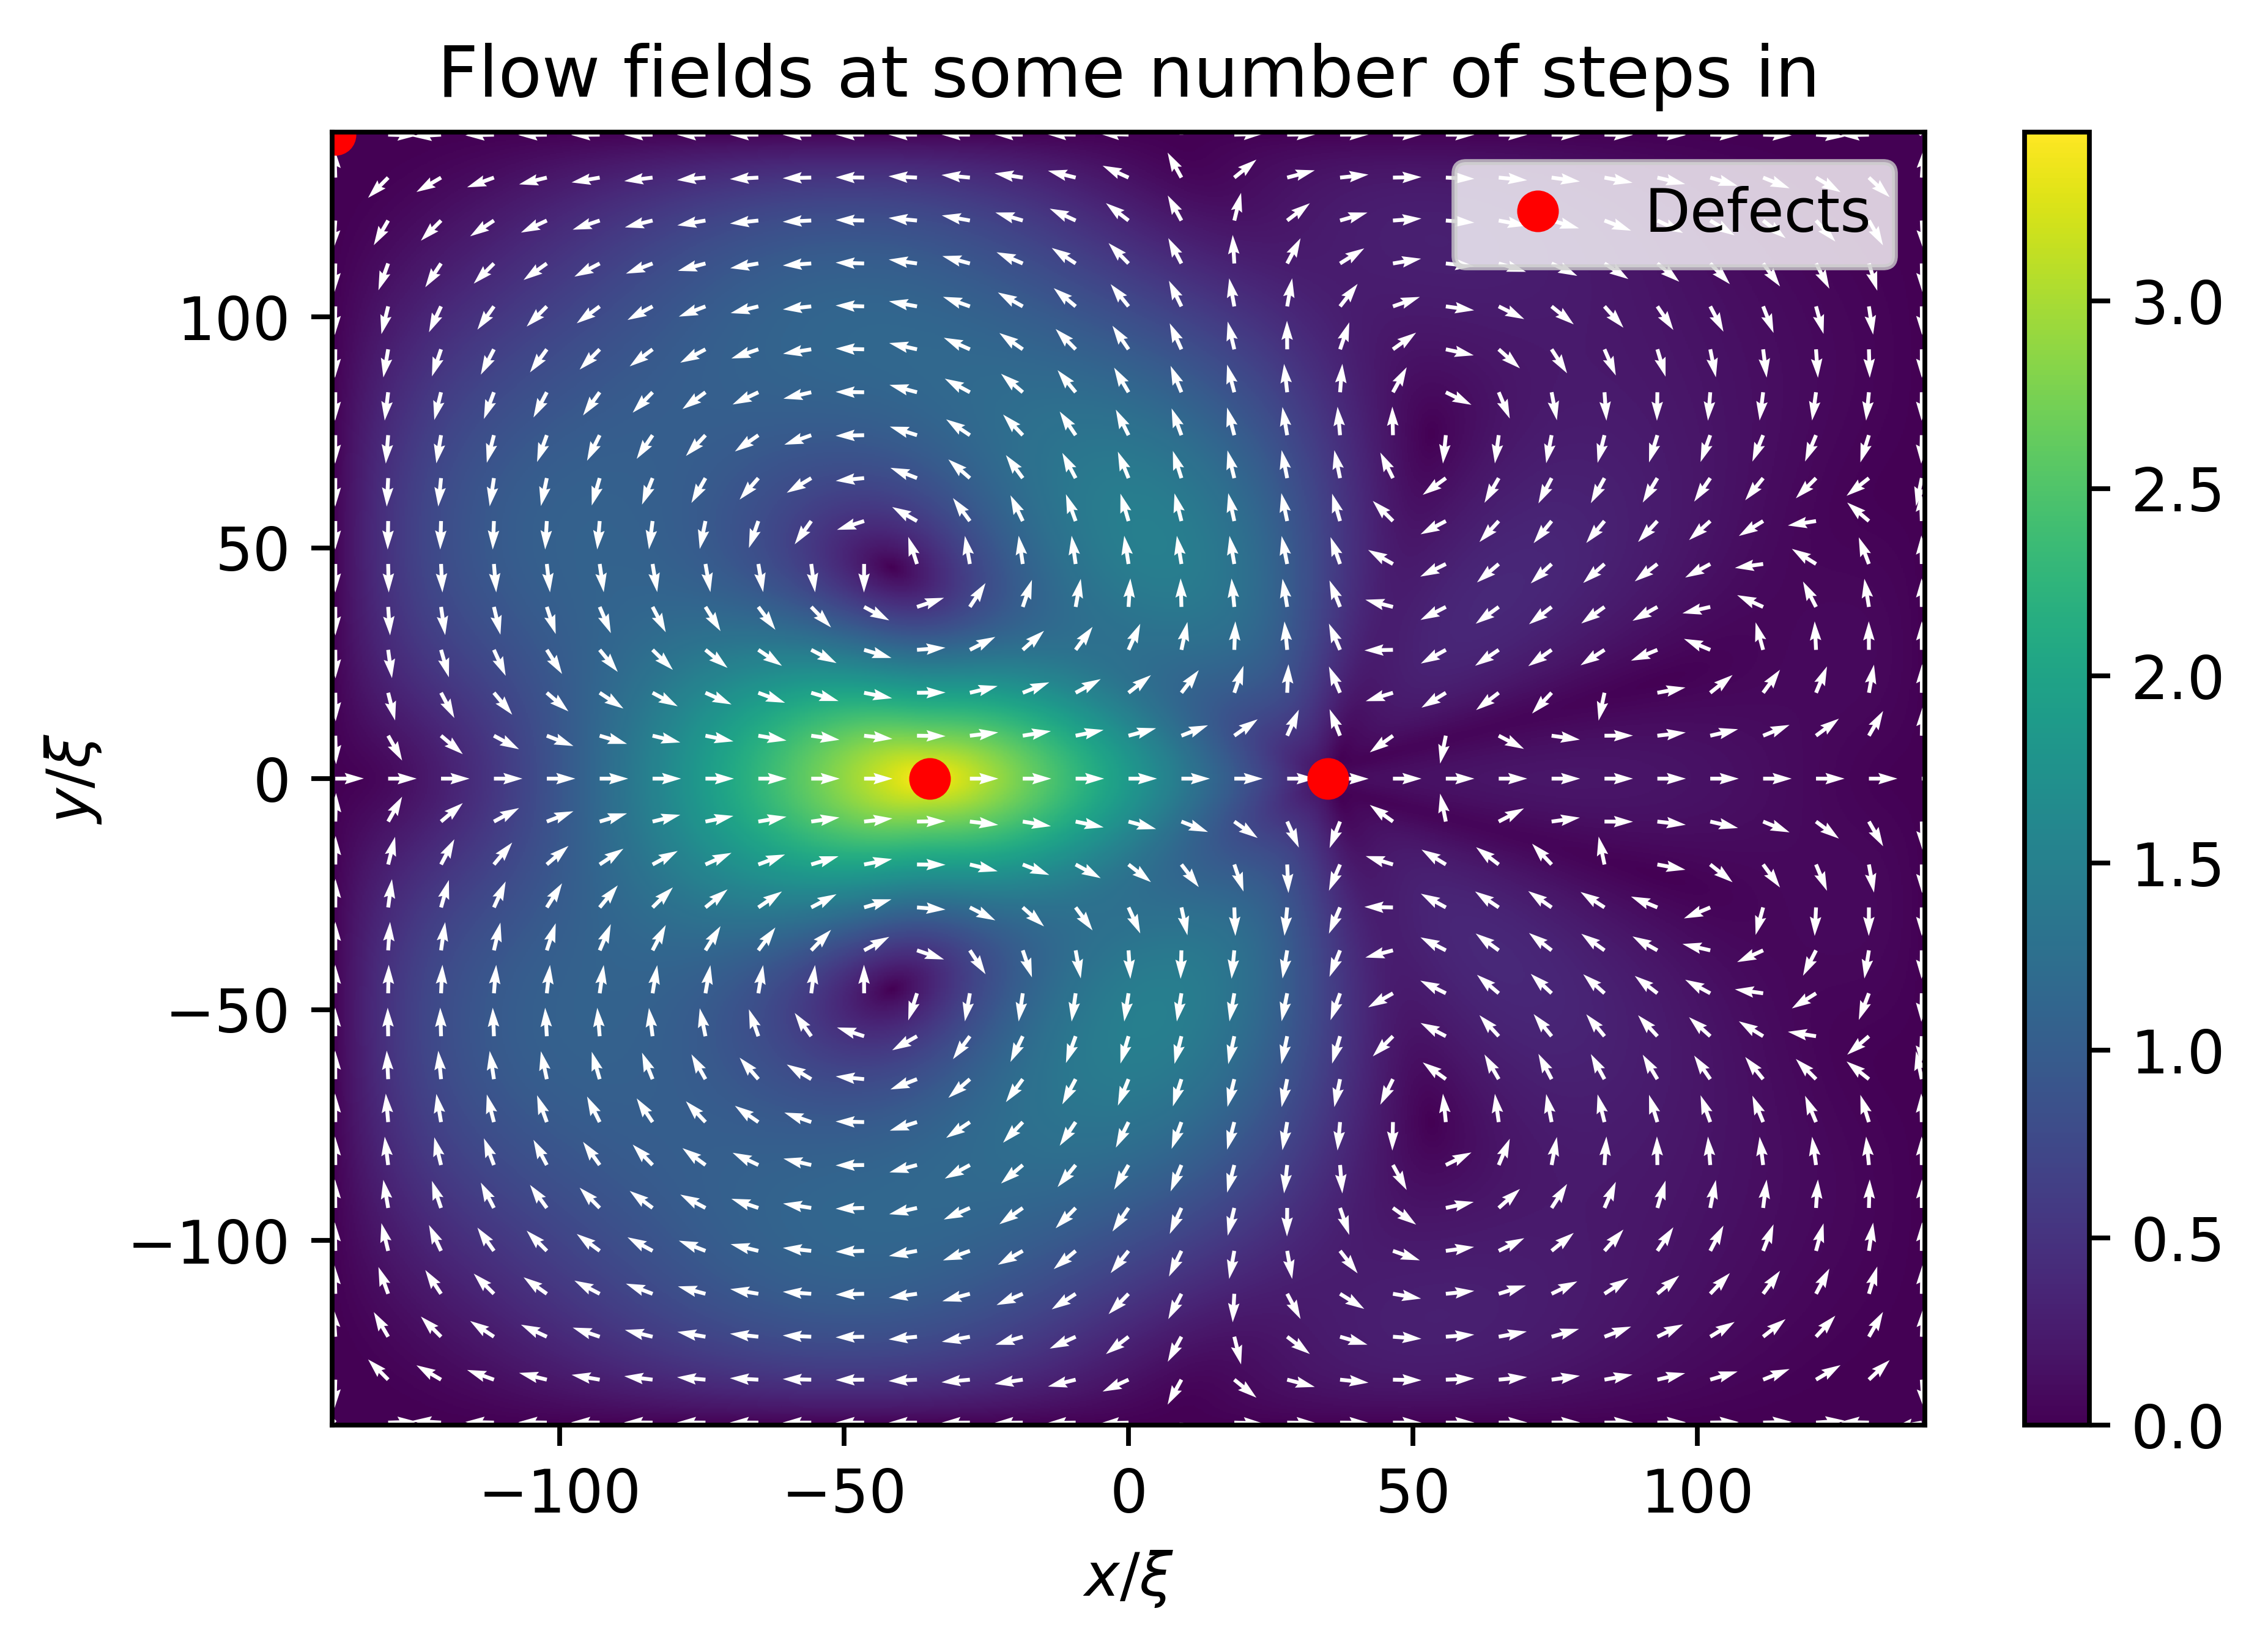

In [108]:
vx, vy = fd.curl(psi, dx)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots()
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], 
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.plot(X[peaks], Y[peaks], marker='o', ls='', c='r', label='Defects')
ax.legend()
ax.set_title('Flow fields at some number of steps in')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')

Text(0, 0.5, '$y/\\xi$')

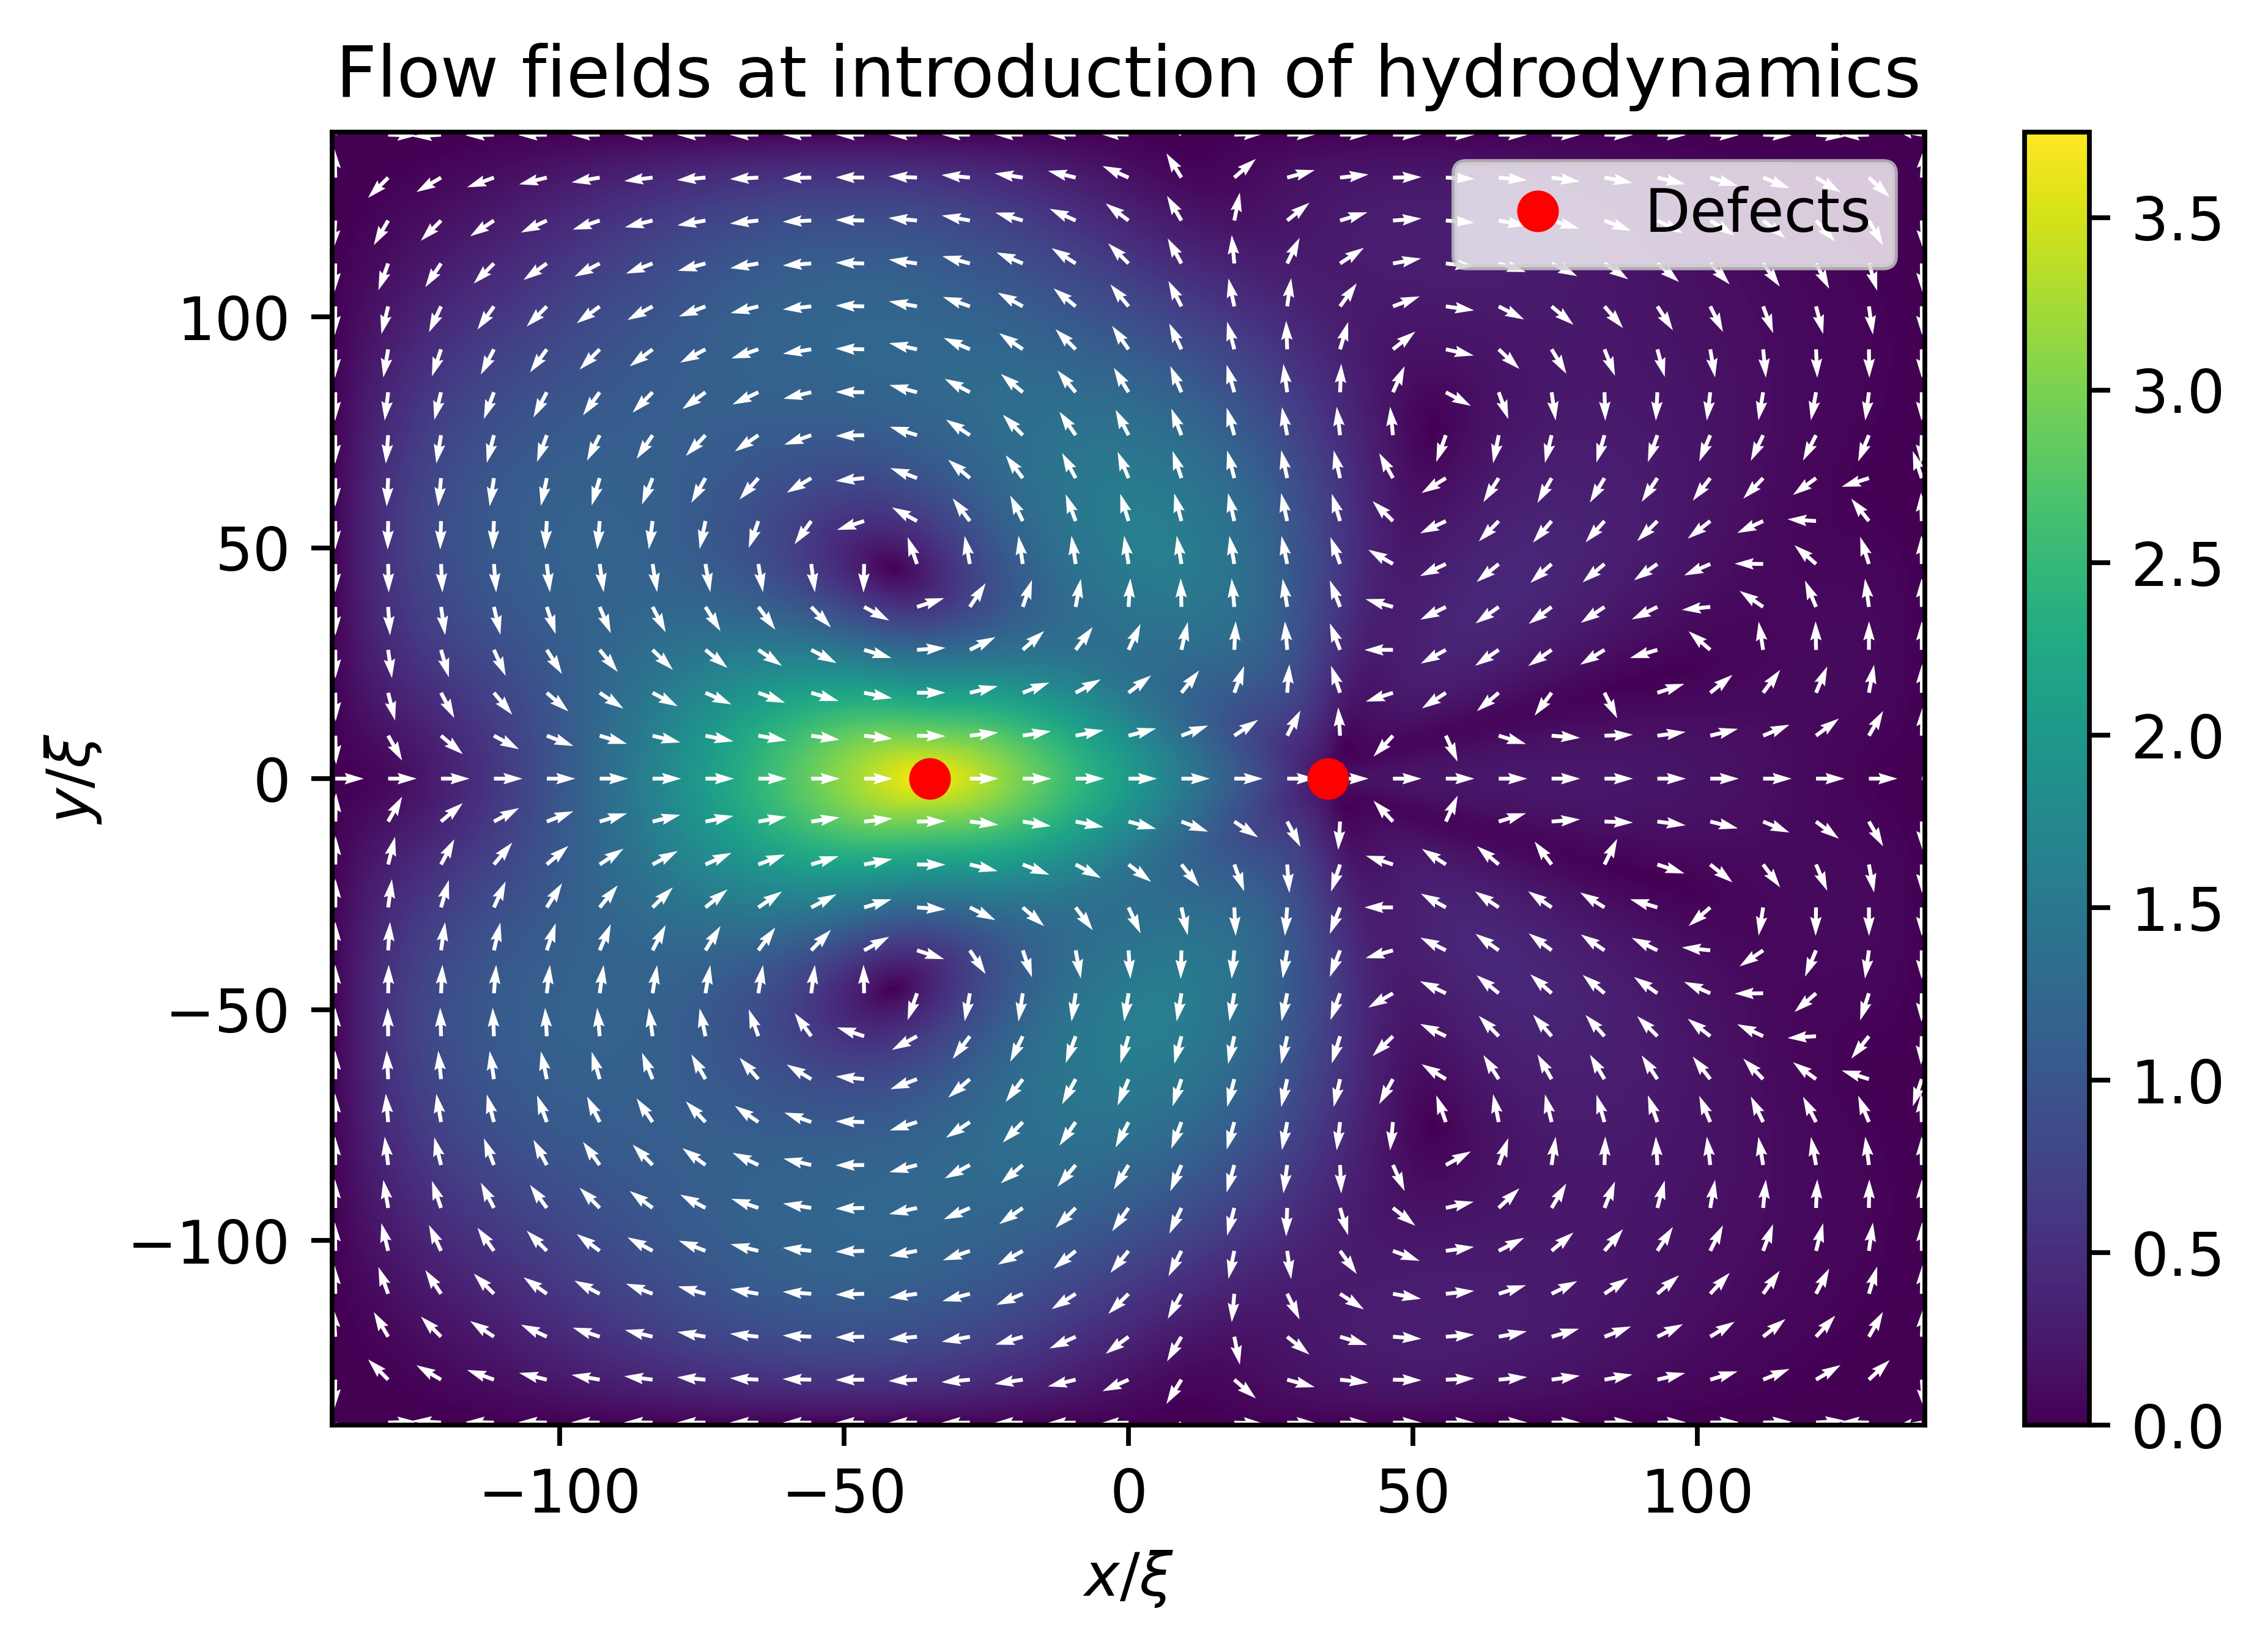

In [109]:
psi_begin = np.zeros(eta_hydro.shape)

source_term_begin = ( lch.beta*lch.f1(eta_hydro, mu_hydro, nu_hydro, dx) 
                     + (1/4)*lch.alpha*lch.f2(eta_hydro, mu_hydro, nu_hydro, dx) )
psi_begin[1:-1, 1:-1], _, _ = bh_solver.solve(source_term_begin[1:-1, 1:-1])

vx, vy = fd.curl(psi_begin, dx)
v = np.sqrt(vx**2 + vy**2)

mask = np.where(v != 0)
vx_norm = np.zeros(vx.shape)
vy_norm = np.zeros(vy.shape)
vx_norm[mask] = vx[mask]/v[mask]
vy_norm[mask] = vy[mask]/v[mask]

sparse_idx = lch.sparseIdx(vx.shape, (30, 30))

fig, ax = plt.subplots()
c = ax.pcolor(X, Y, v)
fig.colorbar(c, ax=ax)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], 
              vx_norm[sparse_idx], vy_norm[sparse_idx], pivot='tail', color='w')
ax.plot(peak_pos[:, 0], np.array([0, 0]), marker='o', ls='', c='r', label='Defects')
ax.legend()
ax.set_title('Flow fields at introduction of hydrodynamics')
ax.set_xlabel(r'$x/\xi$')
ax.set_ylabel(r'$y/\xi$')

### Check the effect of the flow on the simulation

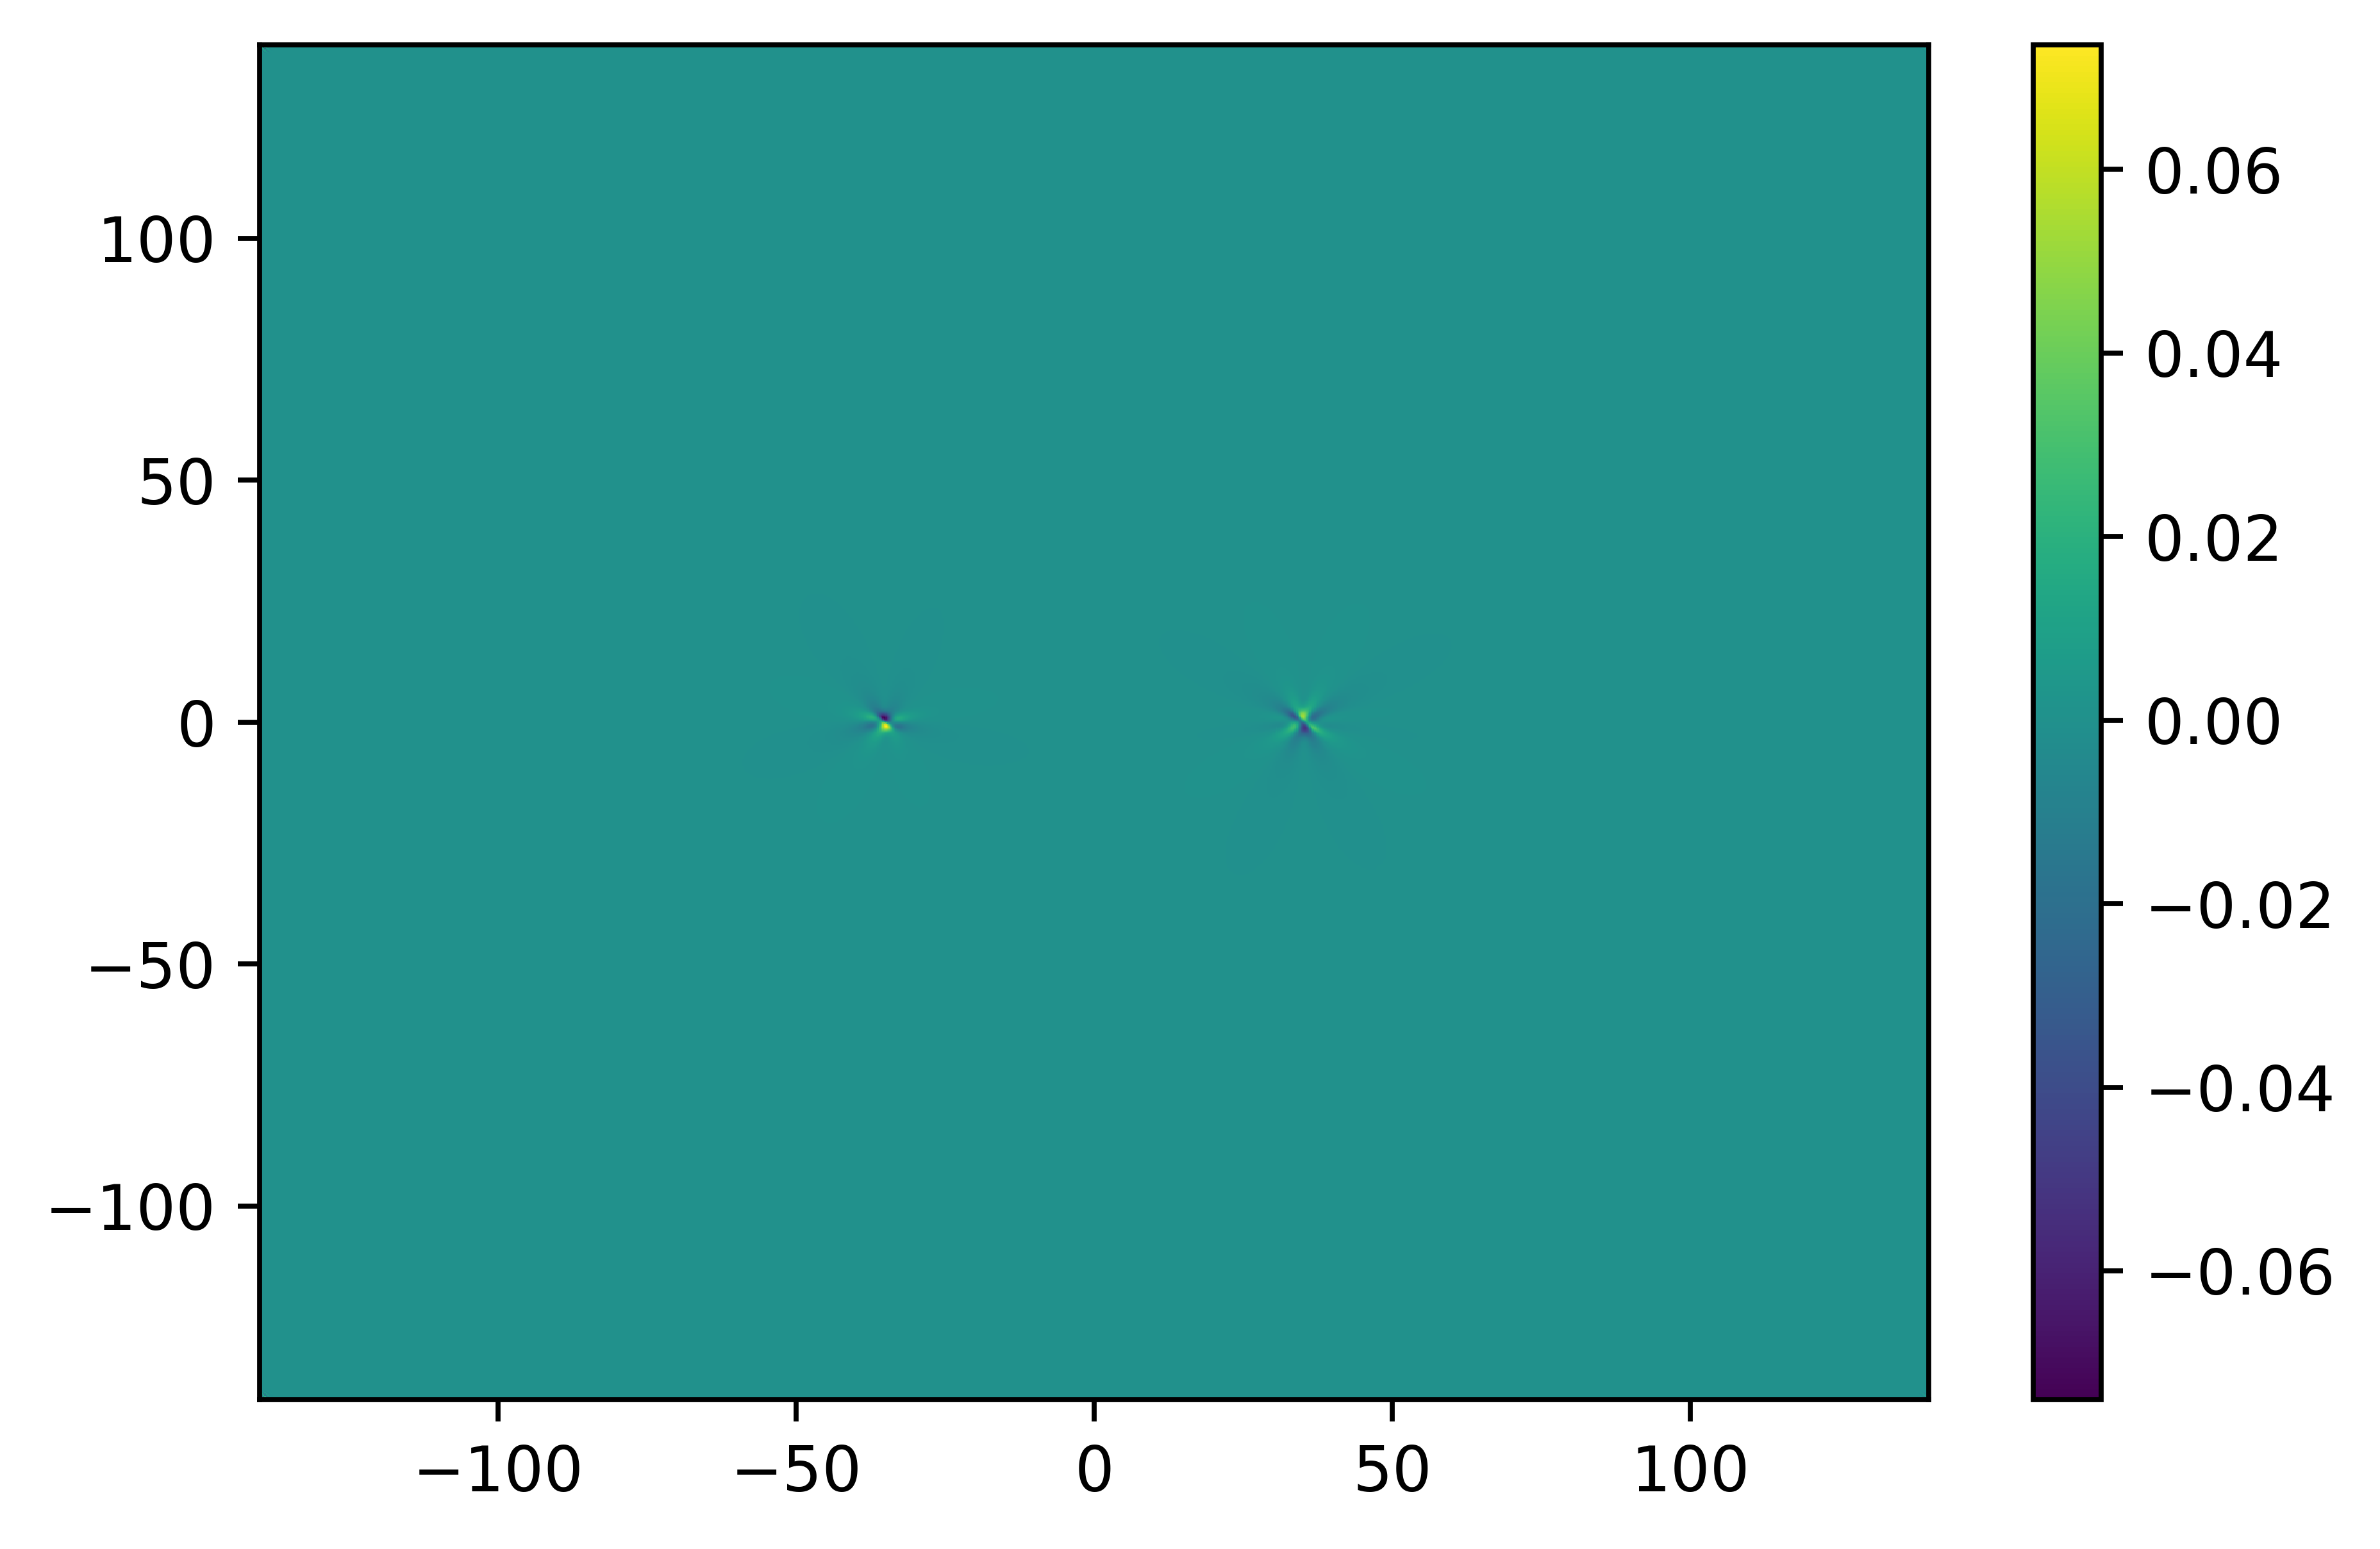

In [110]:
eta_new = lch.etaFlowEOM(eta_old, mu_old, nu_old, psi, dx)
eta_new_flowless = lch.etaEOM(eta_old, mu_old, nu_old, dx)

plt.pcolor(X, Y, eta_new - eta_new_flowless)
plt.colorbar()

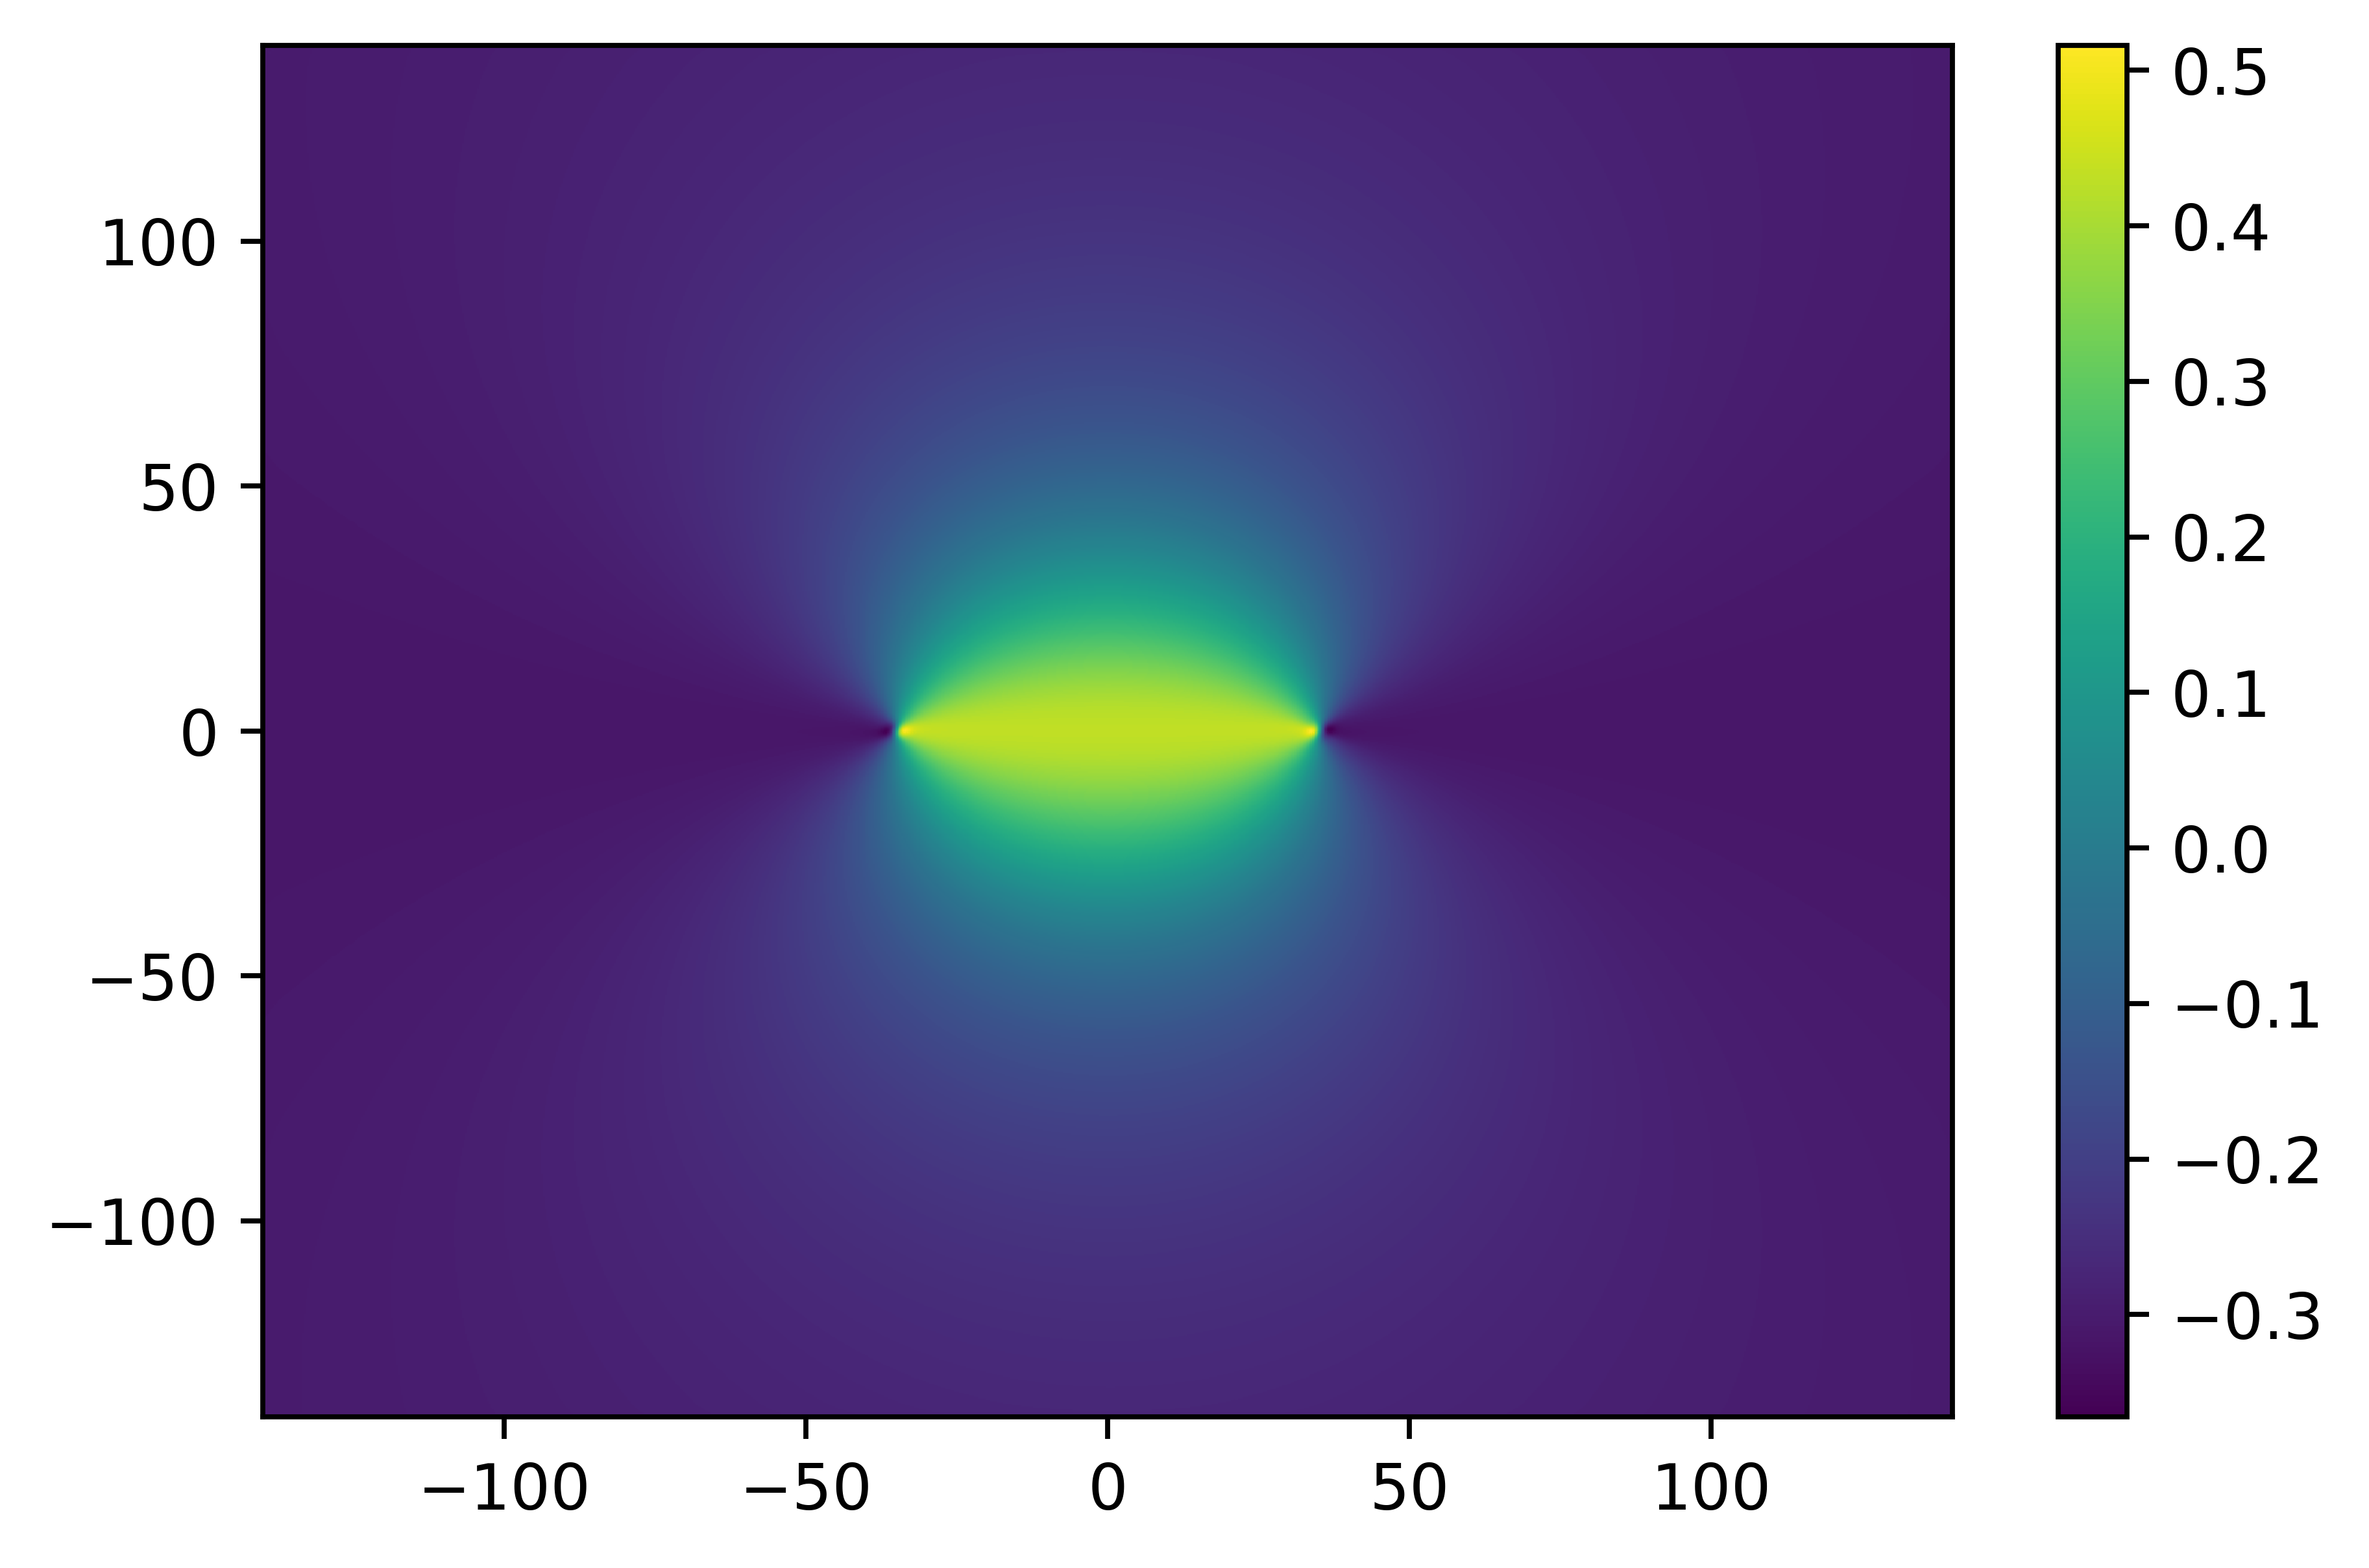

In [111]:
plt.pcolor(X, Y, eta_new)
plt.colorbar()